# Linear models -- Amazon Fine Food Reviews
## Kulikov Alex, gr. 397

В данном домашнем задании вы будете решать задачу классификации отзывов.

Шаги решения:

1. Извлечение признаков: напишите код для создания TF-IDF матрицы из представленного корпуса отзывов
2. Обучение моделей: напишите код для обучения SVM и логистической регрессии
3. Кросс-валидация для подбора гиперпараметров: напишите код для оптимизации метрик обучения
4. Участие в контесте на kaggle.com

In [1]:
import pandas
import random
import numpy
from matplotlib import pyplot as plt
from matplotlib import pyplot

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
pyplot.rcParams['image.interpolation'] = 'nearest'
pyplot.rcParams['image.cmap'] = 'gray'

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

pandas.options.display.max_colwidth = 0

from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

## A super-cool trick for multithreading + visualization
### https://habrahabr.ru/post/277919/

In [3]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [4]:
def jobs_manager():
    from IPython.lib.backgroundjobs import BackgroundJobManager
    from IPython.core.magic import register_line_magic
    from IPython import get_ipython

    jobs = BackgroundJobManager()

    @register_line_magic
    def job(line):
        ip = get_ipython()
        jobs.new(line, ip.user_global_ns)

    return jobs

In [5]:
def kill_thread(thread):
    import ctypes
    
    id = thread.ident
    code = ctypes.pythonapi.PyThreadState_SetAsyncExc(
        ctypes.c_long(id),
        ctypes.py_object(SystemError)
    )
    if code == 0:
        raise ValueError('invalid thread id')
    elif code != 1:
        ctypes.pythonapi.PyThreadState_SetAsyncExc(
            ctypes.c_long(id),
            ctypes.c_long(0)
        )
        raise SystemError('PyThreadState_SetAsyncExc failed')

In [6]:
def get_chunks(sequence, count):
    count = min(count, len(sequence))
    chunks = [[] for _ in range(count)]
    for index, item in enumerate(sequence):
        chunks[index % count].append(item) 
    return chunks

### Demo
#### Just look at that!

In [7]:
jobs = jobs_manager()

In [8]:
from time import sleep
from random import random

def fetch_url(url):
    sleep(random())
    return url

urls = range(100)
urls2 = range(100)

In [9]:
%job [fetch_url(_) for _ in log_progress(urls, every=1)]

Starting job # 0 in a separate thread.


In [10]:
kill_thread(jobs.running[0])

In [11]:
for chunk in get_chunks(urls, 3):
    %job [fetch_url(_) for _ in log_progress(chunk, every=1)]

Starting job # 2 in a separate thread.
Starting job # 3 in a separate thread.
Starting job # 4 in a separate thread.


In [12]:
for job in jobs.running:
    kill_thread(job)

## But tqdm is still better and simpler to use

In [13]:
from tqdm import tqdm
from time import sleep

In [14]:
for i in tqdm(range(10)):
    sleep(1)
    

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


## Знакомство с данными

In [15]:
data = pandas.read_csv("kaggle_data/train.csv", index_col=0, na_values="NaN")

print(data.shape)
print(data.head())
print(data.tail())

(352278, 2)
                                                   Reviews_Summary  Prediction
ID                                                                            
230872  Babies love these                                           3         
344823  Salmon Trout                                                0         
211754  disappointment                                              1         
259421  Doesn't taste like Cinnabon; tastes like Waffle Crisp       2         
253418  Delicious San Daniele prosciutto and good customer service  3         
                             Reviews_Summary  Prediction
ID                                                      
110273  We enjoy this coffee                  3         
259187  Satisfied                             2         
365859  quite good                            3         
131937  Great yummy treat for my little ones  3         
121963  Disappointed                          1         


### Seems that there aren't any missing values..

In [16]:
print(data.Reviews_Summary.value_counts()) # no NaN
# print(data.Reviews_Summary.value_counts()["NaN"]) # -- KeyError
print(data.Prediction.value_counts()) # no NaN
# print(data.Prediction.value_counts()["NaN"]) # -- KeyError

Delicious!                                                       1627
Delicious                                                        1529
Yummy!                                                           1039
Yummy                                                            826 
Yum!                                                             733 
Great product                                                    703 
Excellent                                                        637 
Great Product                                                    622 
Love it!                                                         605 
Great!                                                           527 
Great                                                            486 
Tasty                                                            422 
Yum                                                              412 
Excellent!                                                       376 
Great Coffee        

In [17]:
corpus = data["Reviews_Summary"].values[:1000]
score = data["Prediction"].values[:1000]

In [18]:
print(score[:10])
print(corpus[:10])

[3 0 1 2 3 2 3 2 2 3]
['Babies love these' 'Salmon Trout' 'disappointment'
 "Doesn't taste like Cinnabon; tastes like Waffle Crisp"
 'Delicious San Daniele prosciutto and good customer service'
 'My Dog Loves Them' "My husband's new favorite coffee."
 'Good Job, Betty Crocker' 'Good chips, more cheese'
 "Nature's Hallow Sugar Free Jam"]


Как видите, каждый объект представляет собой отзыв о продукте и оценку по шкале от 0 до 3. Выдвинем гипотезу, что слова, используемые в написании отзыва коррелируют с оценкой, которая была поставлена. Поставим задачу - предсказать оценку, по тексту отзыва.

## 1. Извлечение признаков - 10 Баллов
 

1. Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи вам необходимо написать код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация для решения задачи:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используйте данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Используйте n_features = 3000

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)

corpus_vect = vectorizer.fit_transform(corpus)

print(corpus_vect)

mean_matrix_vect = corpus_vect.mean(axis = 1)

# print(vectorizer.get_feature_names())
# print(corpus_vect.toarray())


  (0, 79)	1
  (0, 666)	1
  (0, 1115)	1
  (1, 938)	1
  (1, 1150)	1
  (2, 318)	1
  (3, 330)	1
  (3, 1094)	1
  (3, 648)	2
  (3, 220)	1
  (3, 1096)	1
  (3, 1196)	1
  (3, 269)	1
  (4, 301)	1
  (4, 943)	1
  (4, 288)	1
  (4, 880)	1
  (4, 50)	1
  (4, 489)	1
  (4, 282)	1
  (4, 969)	1
  (5, 744)	1
  (5, 331)	1
  (5, 672)	1
  (5, 1114)	1
  :	:
  (995, 437)	1
  (996, 672)	1
  (996, 153)	1
  (996, 440)	1
  (996, 1075)	1
  (996, 471)	1
  (996, 1225)	1
  (996, 458)	1
  (996, 1033)	1
  (996, 1021)	1
  (996, 486)	1
  (997, 744)	1
  (997, 331)	1
  (997, 592)	1
  (997, 1118)	1
  (997, 788)	1
  (997, 1215)	1
  (997, 626)	1
  (997, 649)	1
  (998, 503)	1
  (998, 1133)	1
  (998, 41)	1
  (998, 450)	1
  (999, 489)	1
  (999, 232)	1


In [20]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(n_features=3000)
print(type(corpus))

corpus_hashed = hash_vectorizer.transform(corpus)

print(corpus_hashed)

mean_matrix_hash = corpus_hashed.mean(axis = 1)

<type 'numpy.ndarray'>
  (0, 1134)	0.57735026919
  (0, 2170)	0.57735026919
  (0, 2201)	-0.57735026919
  (1, 1353)	-0.707106781187
  (1, 1857)	-0.707106781187
  (2, 1544)	1.0
  (3, 1465)	-0.316227766017
  (3, 1473)	-0.316227766017
  (3, 1480)	-0.316227766017
  (3, 1534)	-0.316227766017
  (3, 1706)	0.316227766017
  (3, 1855)	-0.632455532034
  (3, 2437)	0.316227766017
  (4, 72)	0.353553390593
  (4, 442)	-0.353553390593
  (4, 448)	-0.353553390593
  (4, 845)	-0.353553390593
  (4, 1729)	0.353553390593
  (4, 2369)	0.353553390593
  (4, 2381)	-0.353553390593
  (4, 2860)	-0.353553390593
  (5, 93)	-0.5
  (5, 719)	-0.5
  (5, 1490)	0.5
  (5, 1591)	0.5
  :	:
  (995, 2704)	-0.4472135955
  (996, 49)	-0.316227766017
  (996, 275)	0.316227766017
  (996, 861)	0.316227766017
  (996, 985)	-0.316227766017
  (996, 1092)	-0.316227766017
  (996, 1212)	0.316227766017
  (996, 1563)	-0.316227766017
  (996, 1591)	0.316227766017
  (996, 2344)	0.316227766017
  (996, 2462)	0.316227766017
  (997, 93)	-0.353553390593
  

In [21]:
mean_matrix_hash[:10]

matrix([[ 0.00019245],
        [-0.0004714 ],
        [ 0.00033333],
        [-0.00042164],
        [-0.0002357 ],
        [ 0.        ],
        [-0.00014907],
        [ 0.00066667],
        [ 0.        ],
        [ 0.00044721]])

Для учета важности редких, но показательных слов (термов), используется схема взвешивания TF-IDF. Напишите код, принимающий на вход разреженную матрицу векторного представления документов и возвращающий разреженную матрицу документов, частоты термов которых взвешенны по TF-IDF.

Дополнительная информация для решения задачи:

- Подробнее про TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- Используйте трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

TFIDFtransformer = TfidfTransformer()

corpus_TFIDF = TFIDFtransformer.fit_transform(corpus_hashed)

print(corpus_TFIDF)
corpus_TFIDF


mean_matrix_TFIDF = corpus_TFIDF.mean(axis = 1)

  (0, 2201)	-0.390666501164
  (0, 2170)	0.779067464351
  (0, 1134)	0.490340260287
  (1, 1857)	-0.707106781187
  (1, 1353)	-0.707106781187
  (2, 1544)	1.0
  (3, 2437)	0.400179329608
  (3, 1855)	-0.511667069701
  (3, 1706)	0.251870403554
  (3, 1534)	-0.281490746435
  (3, 1480)	-0.400179329608
  (3, 1473)	-0.400179329608
  (3, 1465)	-0.339250028345
  (4, 2860)	-0.398862124748
  (4, 2381)	-0.42260974453
  (4, 2369)	0.241570983252
  (4, 1729)	0.196491295799
  (4, 845)	-0.221485108061
  (4, 448)	-0.398862124748
  (4, 442)	-0.42260974453
  (4, 72)	0.42260974453
  (5, 1591)	0.561683898009
  (5, 1490)	0.41152000634
  (5, 719)	-0.523493979178
  (5, 93)	-0.491036186919
  :	:
  (995, 179)	-0.436247113522
  (996, 2462)	0.223607164312
  (996, 2344)	0.37541247004
  (996, 1591)	0.286718110855
  (996, 1563)	-0.184805274749
  (996, 1212)	0.327739843415
  (996, 1092)	-0.327739843415
  (996, 985)	-0.339349520165
  (996, 861)	0.354316996698
  (996, 275)	0.310233920079
  (996, 49)	-0.37541247004
  (997, 276

In [23]:
print(mean_matrix_vect[:10])
print(mean_matrix_hash[:10])
print(mean_matrix_TFIDF[:10])

[[ 0.00236035]
 [ 0.00157356]
 [ 0.00078678]
 [ 0.00629426]
 [ 0.00629426]
 [ 0.00314713]
 [ 0.00393391]
 [ 0.00314713]
 [ 0.00314713]
 [ 0.00393391]]
[[ 0.00019245]
 [-0.0004714 ]
 [ 0.00033333]
 [-0.00042164]
 [-0.0002357 ]
 [ 0.        ]
 [-0.00014907]
 [ 0.00066667]
 [ 0.        ]
 [ 0.00044721]]
[[  2.92913741e-04]
 [ -4.71404521e-04]
 [  3.33333333e-04]
 [ -4.26905590e-04]
 [ -3.34585608e-04]
 [ -1.37754206e-05]
 [ -1.31798867e-04]
 [  6.44775804e-04]
 [ -7.92367694e-05]
 [  4.08042424e-04]]


Преобразуем csc матрицу в numpy array

In [24]:
corpus_np = corpus_TFIDF.toarray()

print(corpus_np)
print(corpus_np.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(1000, 3000)


## 2. Код для SVM и логистической регресии - 40 Баллов

После того, как вы получили матрицу признаков, вам необходимо реализовать алгоритм обучения SVM и логистической регрессии. Обе модели являются линейными и отличаются функциями потерь. Для решения оптимизационных задач в обеих моделей будет использоваться стохастический градиентный спуск.

Дополнительная информация для решения задачи:

- Линейные модели: http://cs231n.github.io/linear-classify/
- SGD: http://cs231n.github.io/optimization-1

Начнем с SVM стартовый код находится в файле cs231n/classifiers/linear_svm.py вашей задачей является реализация подсчета функции потерь для SVM

Разбейте обучающую выборку на 2 части train и test

Дополнительная информация для решения задачи:
- Используйте трансформер: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split

In [25]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(corpus_np, score)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(750, 3000)
(250, 3000)
(750,)
(250,)


Транспонируем матрицы с данными, т.к. так будет проще реализовать код SVM

In [27]:
X_train = X_train.transpose()
X_test = X_test.transpose()

Возьмем подвыборки из обучающей выборки, для быстрой проверки кода.

In [28]:
X_train_sample = X_train[:, 0:1000]
y_train_sample = y_train[0:1000]

In [29]:
print(X_train_sample.shape)
print(y_train_sample.shape)

(3000, 750)
(750,)


Найдем чему равен градиент:

In [30]:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = numpy.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
print 'loss: %f' % (loss, )

loss: 3.000200


Градиент равен 0, т.к. код который должен его считать отсутствует. Реализуйте наивную версию и проверьте результат с помощью численного метода расчета. Градиенты должны почти совпадать.

In [31]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000800 analytic: 0.000800, relative error: 7.134922e-09


Теперь реализуйте векторизованную версию расчета фунции потерь - svm_loss_vectorized

In [32]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 3.000200e+00 computed in 0.039408s
Vectorized loss: 3.000200e+00 computed in 0.022170s
difference: -0.000000


Завершите реализацию SVM, реализуйте векторизированную версию расчета градиента.

In [33]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = numpy.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.034995s
Vectorized loss and gradient: computed in 0.022172s
difference: 0.000011


## Stochastic Gradient Descent

In [36]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print 'That took %fs' % (toc - tic)
print 'Current loss is %f' % loss_hist[-1]

iteration 0 / 500: loss 2.999926
iteration 100 / 500: loss 2.498815
iteration 200 / 500: loss 2.075648
iteration 300 / 500: loss 1.858928
iteration 400 / 500: loss 1.731245
That took 410.631081s
Current loss is 1.654567


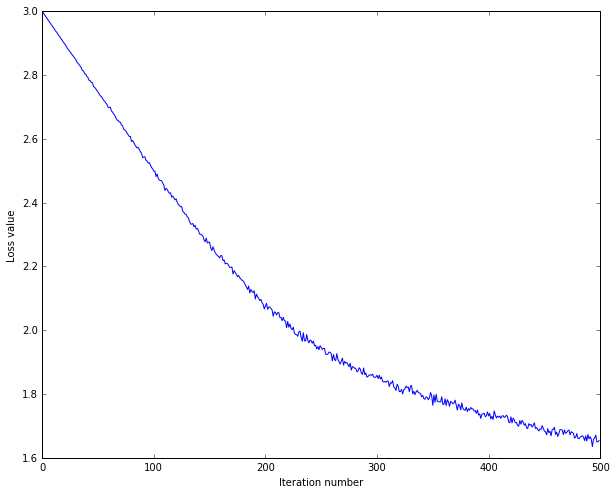

In [37]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [38]:
# Write the LinearSVM.predict function 
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

In [39]:
#and evaluate the performance on both the test set
from sklearn.metrics import classification_report

In [40]:
print classification_report(y_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.40      0.24      0.30        25
          1       0.14      0.07      0.10        14
          2       0.13      0.07      0.09        30
          3       0.76      0.89      0.82       181

avg / total       0.61      0.68      0.64       250



In [41]:
# compare result with the most common dummy classifier
print classification_report(y_test, [3]*len(y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        25
          1       0.00      0.00      0.00        14
          2       0.00      0.00      0.00        30
          3       0.72      1.00      0.84       181

avg / total       0.52      0.72      0.61       250



/usr/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Softmax Classifier

In [42]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = numpy.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-numpy.log(0.1))

loss: 1.386475
sanity check: 2.302585


In [43]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: -0.000327 analytic: -0.000327, relative error: 8.012937e-09
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000621 analytic: 0.000621, relative error: 9.943626e-10
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan


In [45]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = numpy.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % numpy.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 1.386481e+00 computed in 0.054284s
vectorized loss: 1.386481e+00 computed in 0.033899s
Loss difference: 0.000000
Gradient difference: 0.000000


In [46]:
from cs231n.classifiers import Softmax
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print 'That took %fs' % (toc - tic)
print 'Current loss is %f' % loss_hist[-1]

iteration 0 / 500: loss 1.386206
iteration 100 / 500: loss 1.356404
iteration 200 / 500: loss 1.330890
iteration 300 / 500: loss 1.309366
iteration 400 / 500: loss 1.290849
That took 515.802718s
Current loss is 1.278269


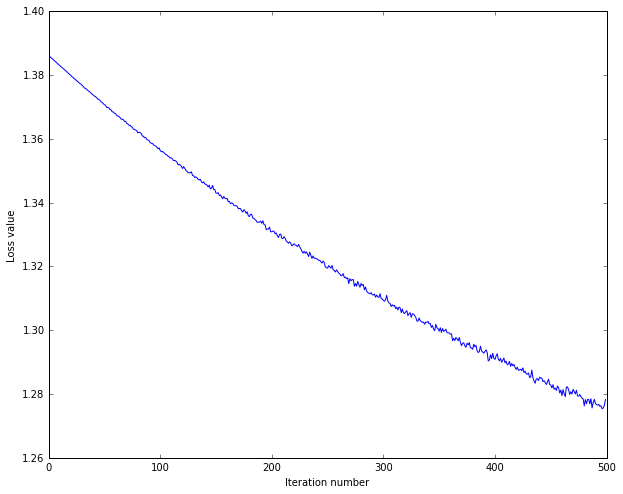

In [47]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [48]:
# Write the LinearSVM.predict function 
y_train_pred = sm.predict(X_train)
y_test_pred = sm.predict(X_test)

In [49]:
print classification_report(y_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.38      0.20      0.26        25
          1       0.14      0.07      0.10        14
          2       0.07      0.03      0.05        30
          3       0.75      0.90      0.82       181

avg / total       0.60      0.68      0.63       250



In [50]:
# compare result with the most common dummy classifier
print classification_report(y_test, [3]*len(y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        25
          1       0.00      0.00      0.00        14
          2       0.00      0.00      0.00        30
          3       0.72      1.00      0.84       181

avg / total       0.52      0.72      0.61       250



## Cross-validation

In [51]:
data = pandas.read_csv("kaggle_data/train.csv", index_col=0, na_values="NaN")

print(data.shape)
print(data.head())
print(data.tail())

(352278, 2)
                                                   Reviews_Summary  Prediction
ID                                                                            
230872  Babies love these                                           3         
344823  Salmon Trout                                                0         
211754  disappointment                                              1         
259421  Doesn't taste like Cinnabon; tastes like Waffle Crisp       2         
253418  Delicious San Daniele prosciutto and good customer service  3         
                             Reviews_Summary  Prediction
ID                                                      
110273  We enjoy this coffee                  3         
259187  Satisfied                             2         
365859  quite good                            3         
131937  Great yummy treat for my little ones  3         
121963  Disappointed                          1         


In [52]:
corpus = data["Reviews_Summary"].values[:1000]
score = data["Prediction"].values[:1000]

In [53]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(n_features=3000)

corpus_hashed = hash_vectorizer.transform(corpus)

# print(corpus_hashed)

mean_matrix_hash = corpus_hashed.mean(axis = 1)

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer

TFIDFtransformer = TfidfTransformer()

corpus_TFIDF = TFIDFtransformer.fit_transform(corpus_hashed)

print(corpus_TFIDF)
corpus_TFIDF


mean_matrix_TFIDF = corpus_TFIDF.mean(axis = 1)

  (0, 2201)	-0.390666501164
  (0, 2170)	0.779067464351
  (0, 1134)	0.490340260287
  (1, 1857)	-0.707106781187
  (1, 1353)	-0.707106781187
  (2, 1544)	1.0
  (3, 2437)	0.400179329608
  (3, 1855)	-0.511667069701
  (3, 1706)	0.251870403554
  (3, 1534)	-0.281490746435
  (3, 1480)	-0.400179329608
  (3, 1473)	-0.400179329608
  (3, 1465)	-0.339250028345
  (4, 2860)	-0.398862124748
  (4, 2381)	-0.42260974453
  (4, 2369)	0.241570983252
  (4, 1729)	0.196491295799
  (4, 845)	-0.221485108061
  (4, 448)	-0.398862124748
  (4, 442)	-0.42260974453
  (4, 72)	0.42260974453
  (5, 1591)	0.561683898009
  (5, 1490)	0.41152000634
  (5, 719)	-0.523493979178
  (5, 93)	-0.491036186919
  :	:
  (995, 179)	-0.436247113522
  (996, 2462)	0.223607164312
  (996, 2344)	0.37541247004
  (996, 1591)	0.286718110855
  (996, 1563)	-0.184805274749
  (996, 1212)	0.327739843415
  (996, 1092)	-0.327739843415
  (996, 985)	-0.339349520165
  (996, 861)	0.354316996698
  (996, 275)	0.310233920079
  (996, 49)	-0.37541247004
  (997, 276

In [55]:
corpus_np = corpus_TFIDF.toarray()

print(corpus_np)
print(corpus_np.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(1000, 3000)


In [56]:
CVX_train = corpus_np
CVy_train = score

In [57]:
CVX_train = CVX_train.transpose()
CVy_train = CVy_train.transpose()

In [58]:

from sklearn import metrics

def accuracy(y_true, y_predict):
    return metrics.accuracy_score(y_true, y_predict)



In [62]:
# Cross validation
from sklearn import cross_validation
from datetime import datetime

def my_cross_validation(X, y, predictor, batch_size, q_fold = 5, r_fold = 5):
    
    scores = []
    
    total_size = X.shape[1]
    
    seed = datetime.now().microsecond + datetime.now().second * 1000000
    
    shuffled_split = cross_validation.ShuffleSplit(total_size, n_iter=r_fold, test_size=1.0/q_fold, random_state=seed)
    
    for train_index, test_index in shuffled_split:
#         print(train_index, test_index)
#         print(X.shape)
        X_train = X[:, train_index]
        y_train = y[train_index]
        X_test = X[:, test_index]
        y_test = y[test_index]
        
        predictor.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)
        
        y_predicted = predictor.predict(X_test)
        
#         predictor = predictor.fit(X_train, y_train)
#         predictor = predictor.calc_dist(X_test, metric)
#         y_predicted = predictor.predict_labels(X_test)
        
        scores.append(accuracy(y_test, y_predicted))
    
    return np.mean(scores)

In [66]:
from cs231n.classifiers import Softmax

my_cross_validation(CVX_train, CVy_train, Softmax(), 2500)

0.74


In [67]:
# for chunk in get_chunks(urls, 3):
#     %job [fetch_url(_) for _ in log_progress(chunk, every=1)]

import sys

for batch_size in [10, 15, 20, 25]:#[10000, 15000, 20000, 25000]:
    %job [sys.stderr.print(my_cross_validation(CVX_train, CVy_train, Softmax(), _)) for _ in log_progress(batch, every=1)]
    

Starting job # 5 in a separate thread.
Starting job # 6 in a separate thread.
Starting job # 7 in a separate thread.
Starting job # 8 in a separate thread.


In [68]:
for job in jobs.running:
    kill_thread(job)

## 3. Kaggle In Class - 50 Баллов

Используйте полученные модели для решения контеста. Выберете одну из моделей, реализуйте настройку гиперпараметров и пайплайн для предсказания классов тестовой выборки для сабмита в систему.

## Disclaimer

Финальные результаты для контеста я получал на другом, более мощном компе (здесь датасет не влезал в оперативку, начинался лютый swap, трешинг и оно могло продолжаться вечно).

Поэтому в этом ноутбуке эта часть не исполнялась.

Однако, в архиве лежит та самая посылка, кажется.

In [3]:
corpus = data["Reviews_Summary"].values[:150000]
score = data["Prediction"].values[:150000]

In [4]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(n_features=3000)

corpus_hashed = hash_vectorizer.transform(corpus)

# print(corpus_hashed)

mean_matrix_hash = corpus_hashed.mean(axis = 1)

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

TFIDFtransformer = TfidfTransformer()

corpus_TFIDF = TFIDFtransformer.fit_transform(corpus_hashed)

print(corpus_TFIDF)
corpus_TFIDF


mean_matrix_TFIDF = corpus_TFIDF.mean(axis = 1)

  (0, 2201)	-0.388087041871
  (0, 2170)	0.797261449037
  (0, 1134)	0.46234470886
  (1, 1857)	-0.585449721059
  (1, 1353)	-0.810708717181
  (2, 1544)	1.0
  (3, 2437)	0.406636837688
  (3, 1855)	-0.472879818054
  (3, 1706)	0.223009443256
  (3, 1534)	-0.276326371382
  (3, 1480)	-0.427133236033
  (3, 1473)	-0.429236822175
  (3, 1465)	-0.343881714801
  (4, 2860)	-0.415063911996
  (4, 2381)	-0.479051022982
  (4, 2369)	0.208293833248
  (4, 1729)	0.166347090244
  (4, 845)	-0.181486200877
  (4, 448)	-0.315606706645
  (4, 442)	-0.35157973944
  (4, 72)	0.520597006681
  (5, 1591)	0.528041718732
  (5, 1490)	0.405698776136
  (5, 719)	-0.567388184332
  (5, 93)	-0.484407983627
  :	:
  (149994, 811)	0.36106911323
  (149994, 582)	0.246338063177
  (149994, 522)	-0.257311653332
  (149994, 312)	0.514746539396
  (149995, 2294)	1.0
  (149996, 2388)	0.341739803231
  (149996, 1801)	0.778369270629
  (149996, 972)	0.526645217797
  (149997, 2958)	-0.338519179805
  (149997, 1298)	-0.494010033191
  (149997, 735)	0.6

In [6]:
corpus_np = corpus_TFIDF.toarray()

print(corpus_np)
print(corpus_np.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(150000, 3000)


In [70]:
KX_train = corpus_np[:10]
Ky_train = score[:10]

In [71]:
KX_train = KX_train.transpose()
Ky_train = Ky_train.transpose()

In [ ]:
from cs231n.classifiers import Softmax
import time
sm = Softmax()
tic = time.time()
loss_hist = sm.train(KX_train, Ky_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print 'That took %fs' % (toc - tic)
print 'Current loss is %f' % loss_hist[-1]

iteration 0 / 500: loss 1.386600


In [ ]:
data_test = pandas.read_csv("kaggle_data/test.csv", na_values="NaN")

print(data_test.shape)
print(data_test.head())
print(data_test.tail())

In [ ]:
KX_test = data_test["Reviews_Summary"]
KIDs = data_test["ID"]

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(n_features=3000)

KX_test_hashed = hash_vectorizer.transform(KX_test)

# print(corpus_hashed)

mean_matrix_hash = KX_test_hashed.mean(axis = 1)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

TFIDFtransformer = TfidfTransformer()

KX_test_TFIDF = TFIDFtransformer.fit_transform(KX_test_hashed)

print(KX_test_TFIDF)
KX_test_TFIDF


mean_matrix_TFIDF = KX_test_TFIDF.mean(axis = 1)

In [ ]:
KX_test = KX_test_TFIDF.toarray()

print(KX_test)
print(KX_test.shape)

In [ ]:
KX_test = KX_test.transpose()

print(KX_test.shape)

In [ ]:
Ky_test_pred = sm.predict(KX_test)

In [ ]:
print(Ky_test_pred)
print(Ky_test_pred.shape)


In [ ]:
print(numpy.unique(Ky_test_pred, return_counts = True)) # no NaN

In [ ]:
import sys

ans = open("kaggle_prediction.csv", "w")

ans.write("ID,class_0,class_1,class_2,class_3\n")

for index in range(KIDs.size):
    ID = KIDs[index]
    class_0 = float(Ky_test_pred[index] == 0)
    class_1 = float(Ky_test_pred[index] == 1)
    class_2 = float(Ky_test_pred[index] == 2)
    class_3 = float(Ky_test_pred[index] == 3)
    ans.write("%d,%.1f,%.1f,%.1f,%.1f\n" % (ID, class_0, class_1, class_2, class_3))
    
ans.close()
    

## Fin